# Lab 1
Hara Kumar (19940905-3676)
Yeongwoo Kim (19890909-7753)

In [1]:
import numpy as np
import maze as mz 
import pandas as pd
import matplotlib.pyplot as plt
from bisect import bisect_right
from random import random

# Problem 1: The Maze and the Random Minotaur

The objective is to escape the maze before time T and without getting caught by the minotaur. We start first by describing the maze as a numpy array. 

In [2]:
# Description of the maze as a numpy array
maze = np.array([
    [0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 1, 1],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 1, 2, 0, 0]
])
# with the convention 
# 0 = empty cell
# 1 = obstacle
# 2 = exit of the Maze

The method `maze.draw_maze()` helps us draw the maze given its numpy array discription.  

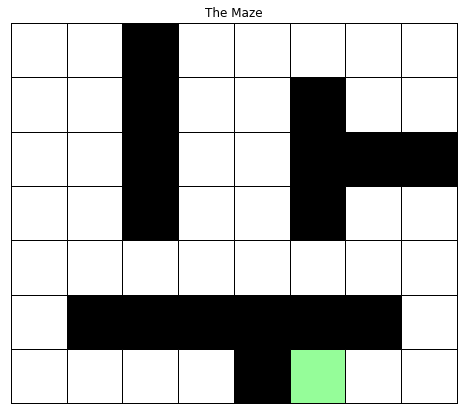

In [3]:
mz.draw_maze(maze)

## MDP formulation

We propose the following MDP formulation: 

#### State space $\mathcal{S}$
We model the state space as the set of all possible positions of the player and the minotaur in the maze. Note that we exclude states where the player is on an obstacles' position since this is an impossible state. We do, however, permit the player to be in the same position as the minotaur, as this possible (the reward for this state will reflect the fact that this is an undesirable state.

$$\mathcal{S} = \big\lbrace (eaten, escaped) \cup (i_a,j_a,i_m,j_m):\textrm{such that } 0<=i<=6,\ 0<=j_a<=7,\ (i'_m,j'_m) \neq (i'_a,j'_a),\ \textrm{and} \\ (i_a,j_a) \notin obstacles, exit \big\rbrace.$$
> **Note:** $\mathcal i_a \textrm{ and } j_a$ represents the position of the agent. $\mathcal i_m \textrm{ and } j_m$ represents the position of the minotaur. The top left corner is position is $(0,0)$ and the bottom right is $(6,7)$.

#### Action space $\mathcal{A}$
If the agent is in the state `eaten` or `escaped` then the only action available is `stay`. Otherwise, we allow the player to chose to either move `left`, `right`, `down`, `up` or not move at all (`stay`).
Formally, the action space when not in state `eaten` or `escaped` is

$$\mathcal{A} = \lbrace \textrm{up, down, left, right, stay}\rbrace.$$

#### Transition probabilities $\mathcal{P}$
There is no randomness involving the movement of the agent. However, there is randomness involving the movement of the minotaur. As our statespace consits of both the minotaur and the agent, there are up to four possible states for each agent action, as described by the following equations. 
- If the minotaur is not at an edge or a corner, it can move in all four cardinal directions.  
$$ (i'_m,j'_m) = \begin{cases}
            (i_m,(j_m + 1)) \quad \textrm{ w.p. } 0.25 \\
            (i_m,(j_m - 1)) \quad \textrm{ w.p. } 0.25 \\
            ((i_m + 1),j_m) \quad \textrm{ w.p. } 0.25 \\
            ((i_m - 1),j_m) \quad \textrm{ w.p. } 0.25
            \end{cases} 
     $$
- If the minotaur is at an edge, it can move in 3 possible directions.       
$$ (i'_m,j'_m) = \begin{cases}
            (i_m,(j_m + 1)) \quad \textrm{ w.p. } 0.33 \textrm{ if in } \mathcal{S} \textrm{ else } 0\\
            (i_m,(j_m - 1)) \quad \textrm{ w.p. } 0.33 \textrm{ if in } \mathcal{S} \textrm{ else } 0\\
            ((i_m + 1),j_m) \quad \textrm{ w.p. } 0.33 \textrm{ if in } \mathcal{S} \textrm{ else } 0\\
            ((i_m - 1),j_m) \quad \textrm{ w.p. } 0.33 \textrm{ if in } \mathcal{S} \textrm{ else } 0
            \end{cases} 
     $$
- If the minotaur is at a corner, it can move in 2 possible directions.       
$$ (i'_m,j'_m) = \begin{cases}
            (i_m,(j_m + 1)) \quad \textrm{ w.p. } 0.5 \textrm{ if in } \mathcal{S} \textrm{ else } 0\\
            (i_m,(j_m - 1)) \quad \textrm{ w.p. } 0.5 \textrm{ if in } \mathcal{S} \textrm{ else } 0\\
            ((i_m + 1),j_m) \quad \textrm{ w.p. } 0.5 \textrm{ if in } \mathcal{S} \textrm{ else } 0\\
            ((i_m - 1),j_m) \quad \textrm{ w.p. } 0.5 \textrm{ if in } \mathcal{S} \textrm{ else } 0
            \end{cases} 
     $$
- After $(i'_m,j'_m)$ is calculated using the above probabilities, they are compared with $(i'_a,j'_a)$. If $(i'_m,j'_m) = (i'_a,j'_a)$, then the new state is $(eaten)$. If not in state `eaten`, then check if $(i'_a,j'_a) = (0,5)$, then the new state is `escaped`. 

> **Note**: If the agent makes an action that results in it running into a wall or obstacle, it will not move. Note also that the action space only makes the action `stay` available when in state `eaten` or `escaped`. The minotaur must move and can ignore obstacles (but can not exit the playing field, this is defined in the state space).

#### Rewards $\mathcal{R}$
For any state and action, the reward r(s,a) is the average value of all possible future states. The value of the future state `escaped` is 1. The value of all other future states, including `eaten` is 0.

> **Note**: Here the rewards are independent of time (i.e. $r_t(.,.) = r(.,.)$). 


### Implementation
The above MDP formulation is implemented as a class ``maze.Maze`` in the file [maze.py](./maze.py) which given a matrix description of the maze instanciates the state space, action space, transition probabilities and rewards. 

> **Note:** In the class `maze.Maze` each state $s = (i,j)$ is given a unique identifier $s_{id} \in \lbrace 0, , \dots, \vert S \vert -1 \rbrace$. In other words, the state space from an implementation perspective is viewed as the set of integers $\lbrace 0, , \dots, \vert S \vert -1 \rbrace$. This mapping is done via the dictionary `self.map` and its inverse mapping via the dictionary `self.states`.   

##  Dynamic Programming 

Before solving the MDP problem, recall that the finite horizon objective function is 
$$
    \mathbb{E} \Big[ \sum_{t=0}^T r(s_t, a_t) \Big],
$$
where $T$ is the horizon.
Recall the Bellman equation 
\begin{equation}
\forall s \in \mathcal{S} \qquad  V(s) = \max_{a \in \mathcal{A}} \Big\lbrace r(s,a) + \sum_{s' \in \mathcal{S}} \mathbb{P}(s'\vert s,a) V(s') \Big\rbrace
\end{equation}
The dynamic programming solution for the finite horizon MDP problem consists of solving the above backward recursion. The method `maze.dynamic_programming` achieves this. 

In [4]:
# Create an environment maze
env = mz.Maze(maze)
env2 = mz.Maze(maze, minotaur_stand_ground=True)

# Finite horizon
horizon = 20

# Solve the MDP problem with dynamic programming 
V, policy = mz.dynamic_programming(env,horizon);
V2, policy2 = mz.dynamic_programming(env2,horizon);

In [5]:
# Run one round of simulation
method = 'DynProg';
start  = (0,0,6,5);
path = env.simulate(start, policy, method);

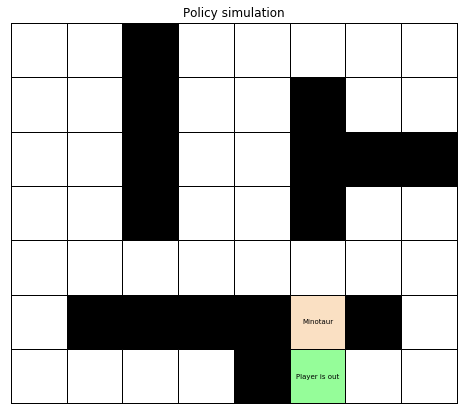

In [6]:
# Show the learned path when the minotaur must move
mz.animate_solution(maze, path)

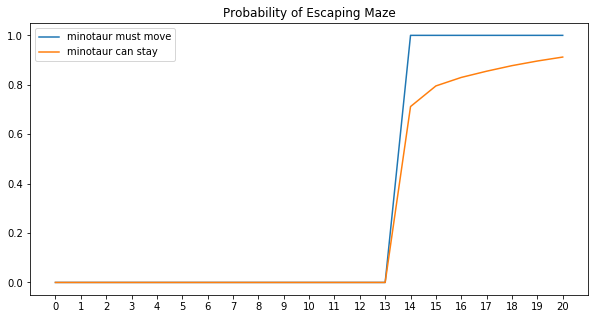

In [9]:
probability_success = [V[(env.map[start],T)] for T in range(horizon, -1, -1)]
probability_success2 = [V2[(env.map[start],T)] for T in range(horizon, -1, -1)]
plt.figure(figsize=(10,5))
plt.xticks(range(horizon+1))
plt.plot(range(horizon+1), probability_success, label='minotaur must move')
plt.plot(range(horizon+1), probability_success2, label='minotaur can stay')
plt.title('Probability of Escaping Maze')
plt.legend()

When the minotaur is allowed to stand still, it can stay on the exit or block the players path forever. This why the probability of escaping the maze is much higher when the minotaur is required to move.

## Value Iteration

Here we solve the discounted infinite-horizon MDP problem using value iteration, the objective here is to find a stationary policy $\pi$ that minimizes the infinite horizon objective with a discount factor $\gamma$ 
$$
    \mathbb{E} \Big[\sum_{t=0}^\infty \gamma^t r\big(s_t, \pi(s_t)\big) \Big].
$$
Recall the Bellman equation in the case of a stationary policy $\pi$ 
\begin{equation}
\forall s \in \mathcal{S} \qquad  V^*(s) = \max_{\pi} \Big\lbrace r(s,\pi(s)) + \gamma \sum_{s' \in \mathcal{S}} \mathbb{P}(s'\vert s,\pi(s)) V^*(s') \Big\rbrace
\end{equation}
or equivalently in terms of the Bellman operator $\mathcal{L}$ 
\begin{equation}
V^* =  \mathcal{L}(V^*)
\end{equation}
where 
\begin{equation}
   \forall s \in \mathcal{S} \qquad  \mathcal{L}(V)(s) = \max_{\pi} \Big\lbrace r(s,\pi(s)) + \gamma \sum_{s' \in \mathcal{S}} \mathbb{P}(s'\vert s,\pi(s)) V(s') \Big\rbrace. 
\end{equation}
Value iteration solves the Bellman equation described above. This method is implemented as `maze.value_iteration` in the file [maze.py]().

> **Note:** Recall that the mapping $\mathcal{L}$ is a contraction, therefore value iteration converges. To achieve an $\varepsilon>0$ approximation (i.e. $\Vert V^* - V_{n+1} \Vert \le \varepsilon$),
 the stopping criterion of value iteration is $\Vert V - \mathcal{L}(V) \Vert < \frac{1-\gamma}{\gamma}\varepsilon$.
 
For this specific problem, $\gamma = 0.967$ because we are interpreting gamma as representing the random time horizon. Per the definition of the problem, the expected value of this time horizon is 30, and $1/(1-0.967) = 30$.

In [3]:
# Create New env for Value Iteration
env3 = mz.Maze(maze)

# Discount Factor 
gamma   = 0.967; 
# Accuracy treshold 
epsilon = 0.0001;
V3, policy3 = mz.value_iteration(env3, gamma, epsilon)

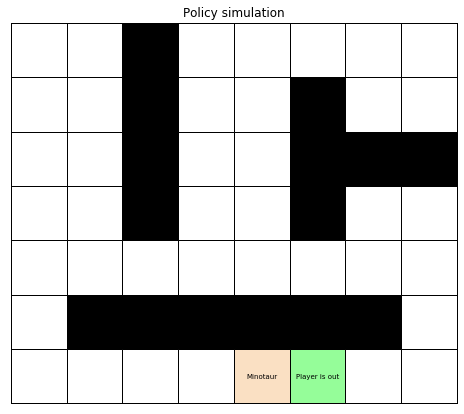

In [4]:
# Run one round of simulation
method3 = 'ValIter';
start3  = (0,0,6,5);
path3 = env3.simulate(start3, policy3, method3)
mz.animate_solution(maze, path3)

In [39]:
# Create a list showing cumulative distribution of game length based on gamma, with the index being the game length
cdd = []
length_of_game = 0
most_recent_cdd = 0
while most_recent_cdd < 0.999:
    most_recent_cdd = most_recent_cdd + (1 - gamma)*(gamma**length_of_game)
    cdd.append(most_recent_cdd)
    length_of_game = length_of_game + 1
    
# Create a function that returns the length of the game at random based on a cumulative distribution
class game_time:
    
    def __init__(self, cdd):
        self.cdd = cdd
    
    def random(self):
        random_double = random()
        pos = bisect_right(self.cdd, random_double)
        if pos == len(self.cdd):
            return pos - 1
        before = self.cdd[pos]
        after = self.cdd[pos + 1]
        if after - random_double < random_double - before:
            return pos + 1 #after
        else:
            return pos #before

game = game_time(cdd)

In [40]:
#Simulating 10,000 games to estimate probability of survival based on this policy
survival = []
length_of_games = []
for i in range (10000):
    length_of_games.append(game.random()) 
    if length_of_games[i] < 15:
        survival.append(False) #If game is shorter than 15 rounds, then there is no hope of escape
    else:
        path_of_this_game = env3.simulate(start3, policy3, method3)
        if length_of_games[i] < len(path_of_this_game): #game ran for too long
            survival.append(False)
        else:
            last_state = path_of_this_game[-1]
            if last_state[0] == last_state[2] and last_state[1] == last_state[3]: #player is eaten
                survival.append(False)
            else:
                survival.append(True)

In [41]:
#Probability of Survival
survival.count(True)/len(survival)

0.5823